In [41]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim

In [42]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

In [43]:
len(train_dataset), len(test_dataset)

(60000, 10000)

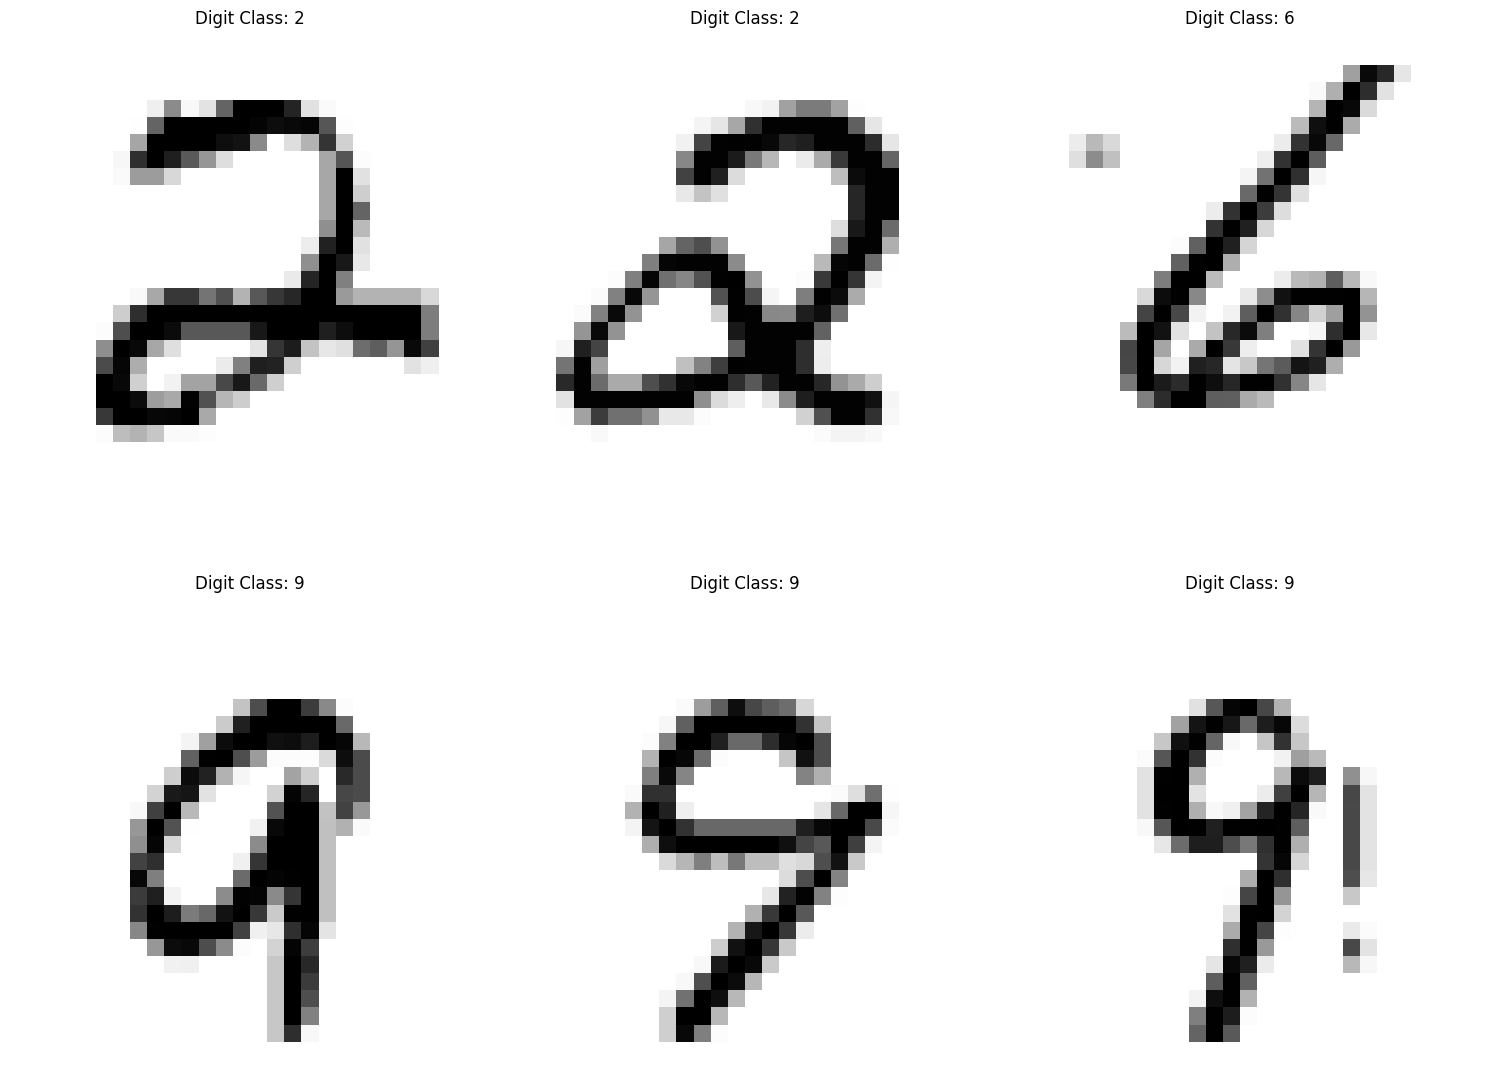

In [44]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [45]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # Block 1
        self.conv1= nn.Conv2d(in_channels= 1,
                              out_channels= 6,
                              kernel_size= 5,
                              stride= 1,
                              padding= 0) # Input: (batch_size, 1, 28, 28), Output: (batch_size, 6, 24, 24)
        self.relu1= nn.ReLU()
        self.pool1= nn.AvgPool2d(kernel_size= 2) # Input: (batch_size, 6, 24, 24), Out: (batch_size, 6, 12, 12)

        # Block 2
        self.conv2= nn.Conv2d(in_channels= 6,
                              out_channels= 16,
                              kernel_size= 5,
                              stride= 1,
                              padding= 0) # Input: (batch_size, 6, 12, 12), Out: (batch_size, 16, 8, 8)
        self.relu2= nn.ReLU()
        self.pool2= nn.AvgPool2d(kernel_size= 2, stride= 2) # In: (batch_size, 16, 8, 8), Out: (batch_size, 16, 4, 4)

        self.fc1= nn.Linear(256, 120) # In: 16x4x4= 256, Out: 120
        self.relu3= nn.ReLU()

        self.fc2= nn.Linear(120, 84) # In: 120, Out: 84
        self.relu4= nn.ReLU()

        self.output= nn.Linear(84, 10) # In: 84, Out: 10 (Num of classes)

        # Initialize weights and bias for linear layers
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.output.weight, mode='fan_in', nonlinearity='relu')

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):
        # Conv
        features= self.pool1(self.relu1(self.conv1(x)))
        features= self.pool2(self.relu2(self.conv2(features)))
        # Classification
        features= features.view(features.size(0), -1)
        features= self.relu3(self.fc1(features))
        features= self.relu4(self.fc2(features))
        # Out Logits
        output= self.output(features)

        return output

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.relu3.register_forward_hook(forward_hook)
        self.relu3.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.relu4.register_forward_hook(forward_hook)
        self.relu4.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [46]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 1024) # Input Shape: 28x28= 784, Out Shape: 512
        nn.init.kaiming_normal_(self.fc1.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu1= nn.ReLU()
        self.dropout1= nn.Dropout(0.3)

        self.fc2= nn.Linear(1024, 512) # Input Shape: 512, Out Shape: 256
        nn.init.kaiming_normal_(self.fc2.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu2= nn.ReLU()
        self.dropout2= nn.Dropout(0.3)

        self.fc3= nn.Linear(512, 256)
        nn.init.kaiming_normal_(self.fc3.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu3= nn.ReLU()
        self.dropout3= nn.Dropout(0.3)

        self.output= nn.Linear(256, 10) # In Shape: 256, Outshape: num classes = 10

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)
        if self.fc3.bias is not None:
            nn.init.constant_(self.fc3.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)

        features= self.dropout1(self.relu1(self.fc1(x)))
        features= self.dropout2(self.relu2(self.fc2(features)))
        features= self.dropout3(self.relu3(self.fc3(features)))

        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.fc3.register_forward_hook(forward_hook)
        self.fc3.register_full_backward_hook(backward_hook)


        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.relu3.register_forward_hook(forward_hook)
        self.relu3.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [47]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     target_accuracy= None,
                     scheduler= None
                     ):
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []
    activation_std_history= []
    gradient_std_history= []
    patience= 3
    best_val_accuracy= 0.0
    epochs_with_no_improvement= 0
    min_delta= 0.1
    model.register_std_hooks()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0
        train_total= 0

        for images, labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss+= loss.item()

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        model.log_std_to_history()
        activation_std_history.append(model.activation_std_history[-1])
        gradient_std_history.append(model.gradient_std_history[-1])

        model.eval()
        running_val_loss= 0.0
        val_correct= 0.0
        val_total= 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss.item()

                # Calculate Val Accuracy
                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)


        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        if val_acc >= best_val_accuracy + min_delta:
            best_val_accuracy= val_acc
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1

        # Log to history and print
        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("Activation STDs:", model.activation_std_history[-1])
        print("Gradient STDs:", model.gradient_std_history[-1])
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at epoch {epoch + 1}. No accuracy improvement after {patience} epochs")
            break

        if scheduler:
            scheduler.step(metrics= val_loss_history[-1])

    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
        "activation_std_history": activation_std_history,
        "gradient_std_history": gradient_std_history
    }


In [48]:
torch.manual_seed(42)
LEARNING_RATE_ADAM= 0.008
LEARNING_RATE_SGD= 0.01
NUM_EPOCHS= 30

lambda_sgd= 1e-6
lambda_adam= 1e-6
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()
label_smoothing_loss_fn= nn.CrossEntropyLoss(label_smoothing= 0.1)



# Label Smoothing + Dropout Model
mlp_model= MLP()
mlp_optimizer= optim.SGD(mlp_model.parameters(), LEARNING_RATE_SGD, momentum= 0.9)
mlp_scheduler= optim.lr_scheduler.ReduceLROnPlateau(mlp_optimizer, mode= 'min', factor= 1e-2, patience= 2)

# Lenet5 with Adam
lenet_adam_model= LeNet5()
lenet_adam_optimizer= optim.Adam(lenet_adam_model.parameters(), LEARNING_RATE_ADAM)
lenet_adam_scheduler= optim.lr_scheduler.ReduceLROnPlateau(lenet_adam_optimizer, mode= 'min', factor= 1e-2, patience= 2)

# Lenet5 with SGD
lenet_sgd_model= LeNet5()
lenet_sgd_optimizer= optim.SGD(lenet_sgd_model.parameters(), LEARNING_RATE_SGD, momentum= 0.9)
lenet_sgd_scheduler= optim.lr_scheduler.ReduceLROnPlateau(lenet_sgd_optimizer, mode= 'min', factor= 1e-2, patience= 2)



print(f"Label Smoothing and Dropout Control MLP Training Start...")
print(f"-"*80)
mlp_model.to(device)
mlp_model_metrics= train_eval_model(model= mlp_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= mlp_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= label_smoothing_loss_fn,
                                scheduler= mlp_scheduler)
print(f"-"*80)
print(f"LeNet5 With Adam Optim Training Start...")
print(f"-"*80)
lenet_adam_model.to(device)
lenet_adam_model_metrics= train_eval_model(model= lenet_adam_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= lenet_adam_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= lenet_adam_scheduler)
print(f"-"*80)
print(f"Lenet5 With SGD Optim Training Start...")
print(f"-"*80)
lenet_sgd_model.to(device)
lenet_sgd_model_metrics= train_eval_model(model= lenet_sgd_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= lenet_sgd_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= lenet_sgd_scheduler)
print(f"-"*80)

Label Smoothing and Dropout Control MLP Training Start...
--------------------------------------------------------------------------------
Epoch 1/30 
----------
Train Loss: 0.8025
Train Accuracy: 90.66%
Val Loss: 0.6145
Val Accuracy: 96.83%
Activation STDs: {'Linear': 1.6248458623886108, 'ReLU': 0.6627859473228455}
Gradient STDs: {'Linear': 0.0002014074707403779, 'ReLU': 0.0003775583172682673}
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 0.6623
Train Accuracy: 96.13%
Val Loss: 0.5873
Val Accuracy: 97.49%
Activation STDs: {'Linear': 1.584165096282959, 'ReLU': 0.6263575553894043}
Gradient STDs: {'Linear': 0.00015908709610812366, 'ReLU': 0.00032393194851465523}
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 0.6292
Train Accuracy: 97.19%
Val Loss: 0.5819
Val Accuracy: 97.85%
Activation STDs: {'Linear': 1.5300655364990234, 'ReLU': 0.6141398549079895}
Gradient STDs: {'Linear': 0.0001728296629153192, 'ReLU': 0.00

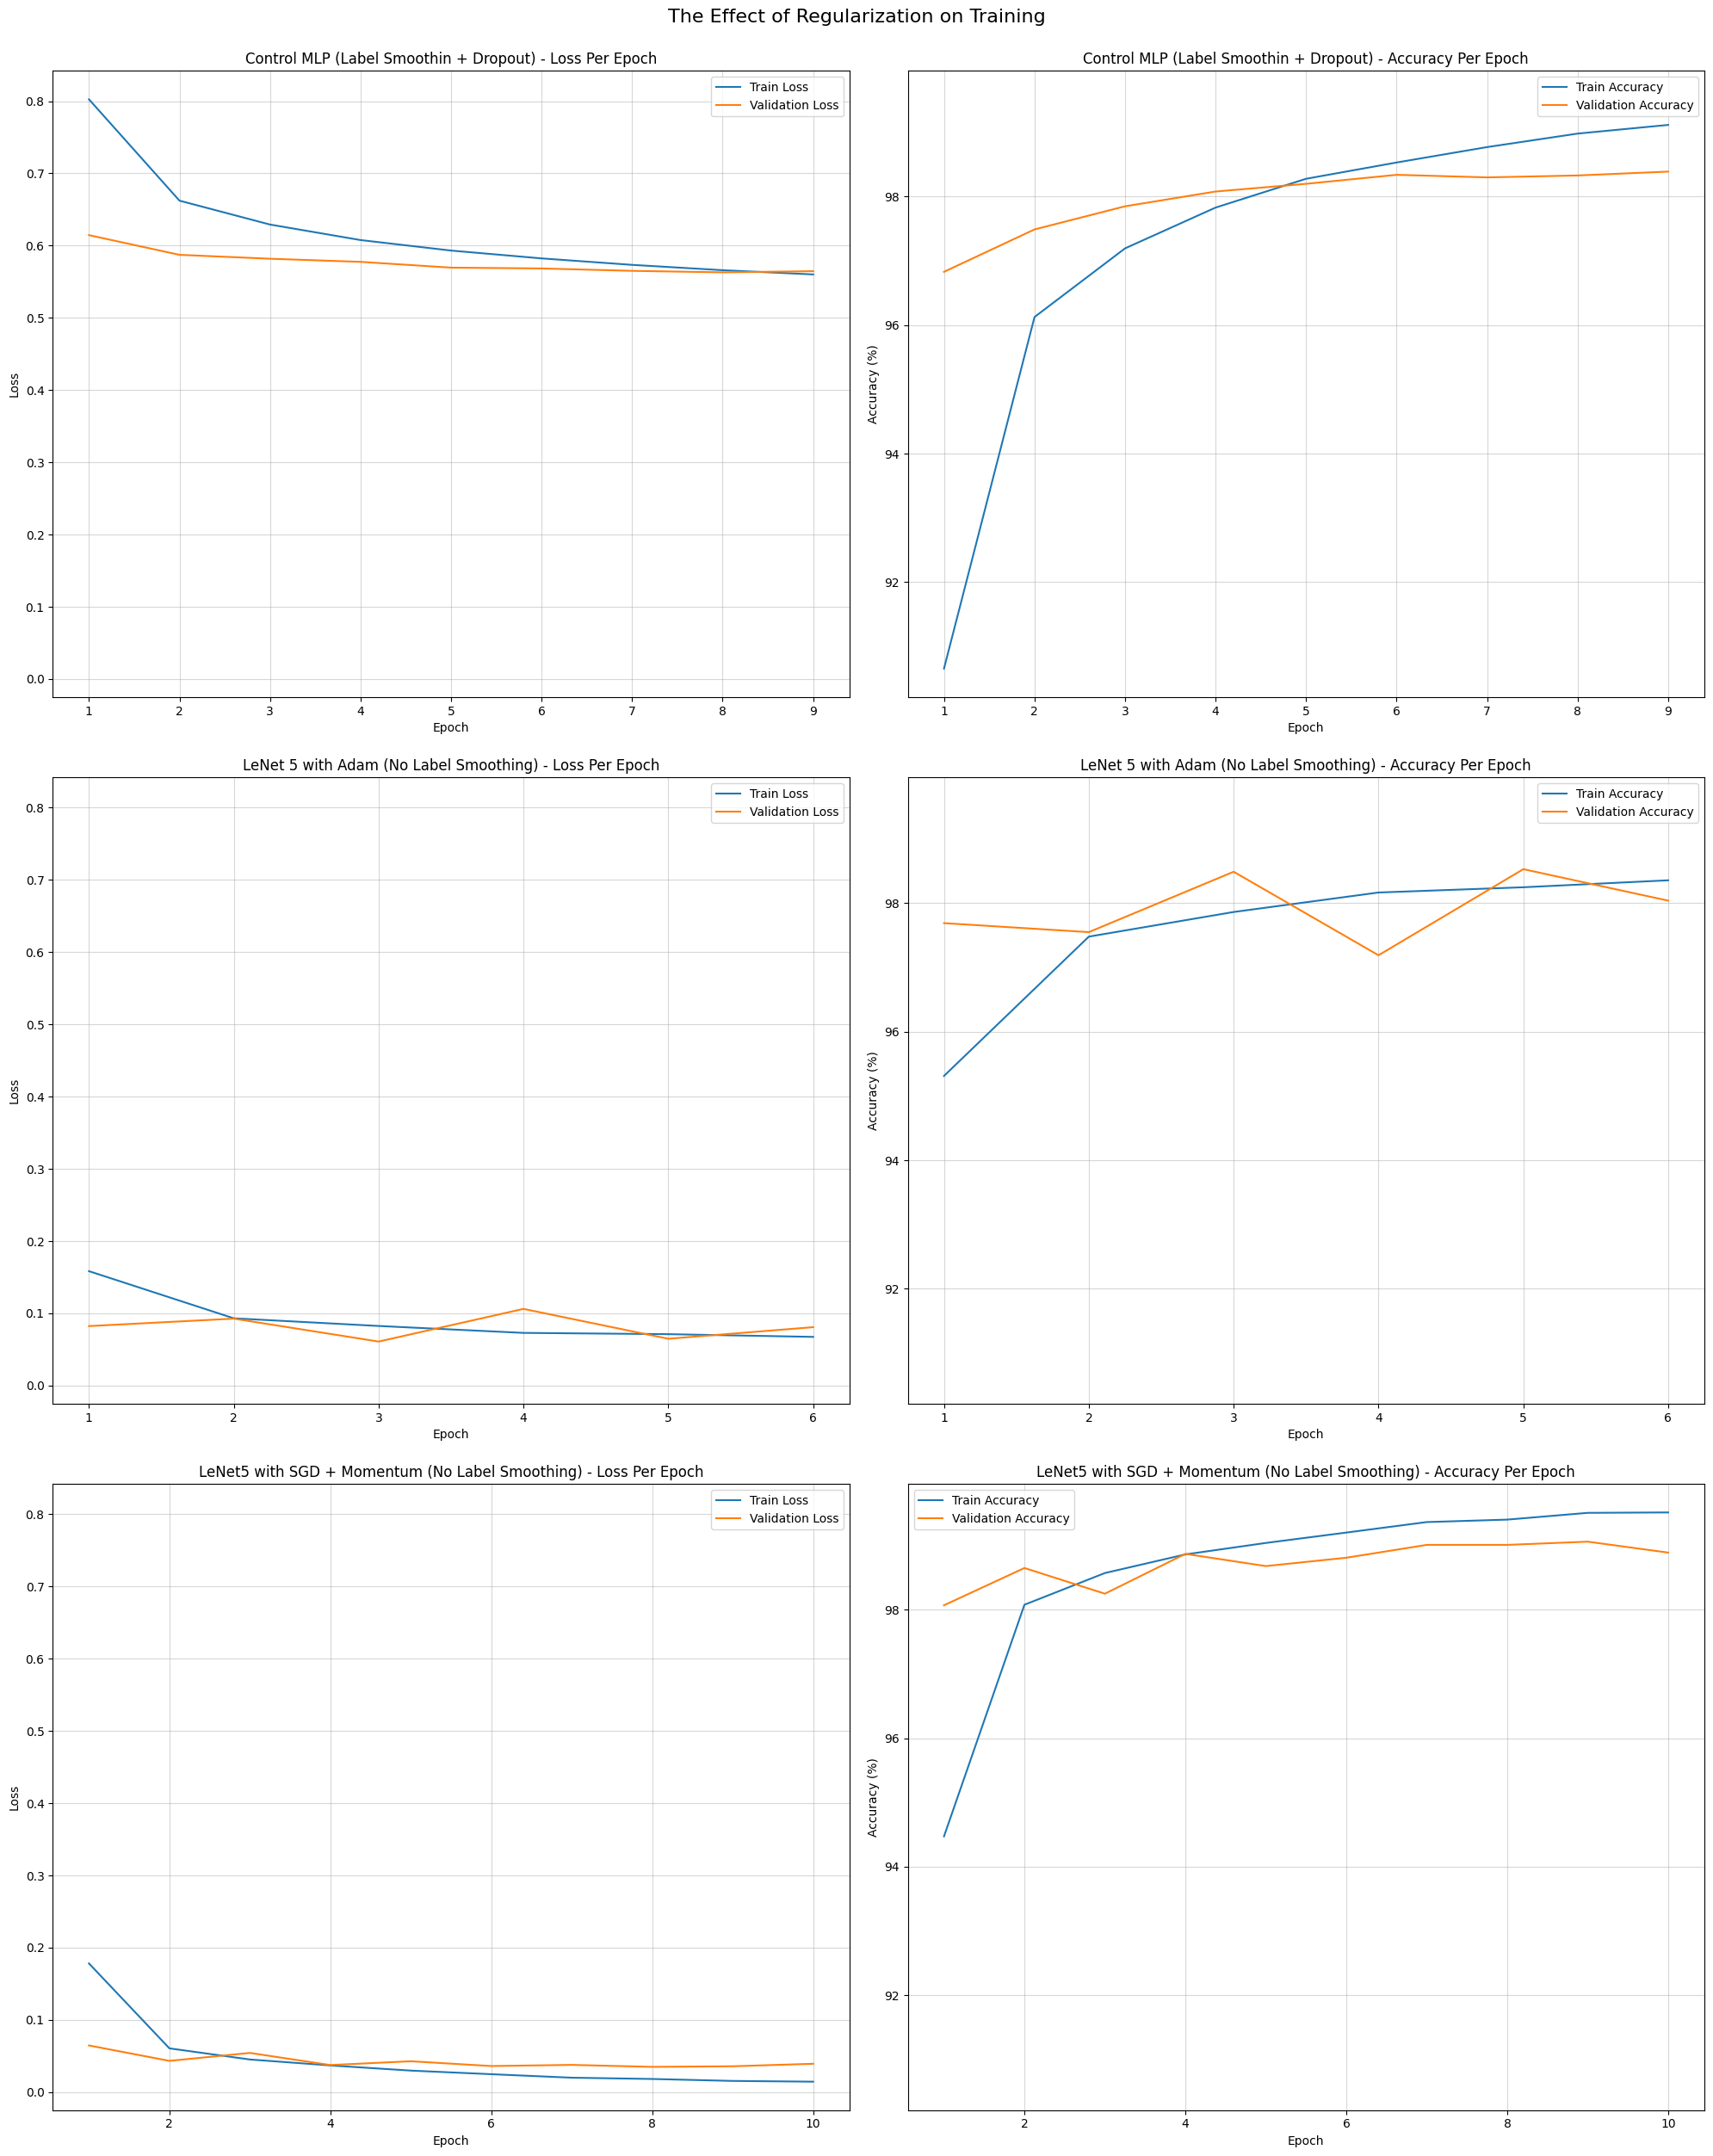

In [49]:
# Create figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(20, 25))

# Data to plot (model metrics)
models_data = [
    (mlp_model_metrics, "Control MLP (Label Smoothin + Dropout)"),
    (lenet_adam_model_metrics, "LeNet 5 with Adam (No Label Smoothing)"),
    (lenet_sgd_model_metrics, "LeNet5 with SGD + Momentum (No Label Smoothing)")
]

# Precompute global min and max for loss and accuracy
all_losses = []
all_accuracies = []
for metrics, _ in models_data:
    all_losses.extend(metrics["train_loss_history"])
    all_losses.extend(metrics["val_loss_history"])
    all_accuracies.extend(metrics["train_acc_history"])
    all_accuracies.extend(metrics["val_acc_history"])

# Add 5% padding to the ranges
loss_padding = (max(all_losses) - min(all_losses)) * 0.05
acc_padding = (max(all_accuracies) - min(all_accuracies)) * 0.05

# Set consistent y-axis limits for all plots
for i in range(3):
    # Left column (loss plots)
    axes[i, 0].set_ylim(min(all_losses) - loss_padding, max(all_losses) + loss_padding)

    # Right column (accuracy plots)
    axes[i, 1].set_ylim(min(all_accuracies) - acc_padding, max(all_accuracies) + acc_padding)

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"The Effect of Regularization on Training",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()